In [1]:
import pandas as pd
import numpy as np
import re
import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({'font.size': 30})

import seaborn as sns
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
sns.set_style("whitegrid")

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler

In [4]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


import spacy
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()

from wordcloud import WordCloud

## Подготовка датасета ##

In [5]:
# чтение датасета
df = pd.read_csv("train_spam.csv")
print(df.shape)
df.head()

(16278, 2)


,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [7]:
# отсутствующие данные
print("Нет пропусков" if sum(df.isnull().mean())==0 else "Есть пропуски")

Нет пропусков


**Удаление дубликатов**

In [8]:
# проверка на дубликаты 
df_dedupped = df.drop_duplicates()
print("Нет дубликатов" if df_dedupped.shape == df.shape else "Есть дубликаты")

Есть дубликаты


In [9]:
df.groupby("text")["text_type"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 5)

,len,max
text,,
SPAM ALERT 🚔 User: Username: @DillyBubbles [919146958] Trust: 81.607 Spammer: False Reputation: -30 NSFW Count: 3 Potential Spammer: False Blacklisted: False Spam Probability: 71 % Message has been deleted,7,ham
SPAM DETECTION User: Username: @DillyBubbles [919146958] Trust: 81.607 Spammer: False Reputation: -30 NSFW Count: 3 Potential Spammer: False Blacklisted: False Content:,4,ham
/ban,3,ham
+ youtube search is limited to channel?,1,ham
radhe movie🎥🎥 full hd 720p new release movie see and enjoy stay home stay safe and channel ke link ko jayda shere kroge to aapki demand ki movie upload krta rahuga,1,spam


In [10]:
df_dedupped.shape

(16267, 2)

**Кодирование классов**

In [11]:
# 1 - spam, 0 - ham
df_cleaned = pd.DataFrame()
label_encoder = LabelEncoder()
df_cleaned["text_type"] = label_encoder.fit_transform(df_dedupped["text_type"])

**Очистка текста от символов**

In [12]:
def cleanText(row):
    #for char in string.punctuation:
    #    row = row.replace(char, '')
    row = re.sub('[^a-zA-Z]', ' ', row)
    row = row.split()
    return ' '.join(row)
    
df_cleaned["cleaned"] = df_dedupped["text"].apply(cleanText)
print(*df_cleaned["cleaned"][:5], sep = "\n\n")

make sure alex knows his birthday is over in fifteen minutes as far as youre concerned

a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski pm to molly magee hou ect ect cc vince j kaminski hou ect ect subject a resume for john lavorato molly please make arrangements for the interview with this candidate for a trading position interviews with john lavorato jeff shankman gary hickerson stinson gibner i talked to him in new york and he is considering other opportunities so we have to act fast i think john will like him more than punit thanks

plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect and ads

urgent your mobile number has been awarded with a prize guaranteed call from land line claim valid hrs only ppm

overview of hr associates analyst project per david s request attached is an overview of the hr associates analysts project creating a human resource value index this docu

Некоторые сообщения состояли только из символов, поэтому теперь там ненужные nan

In [13]:
# удаление nan
df_cleaned = df_cleaned[~df_cleaned["cleaned"].isnull()]
df_cleaned

,text_type,cleaned
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...
...,...,...
16262,1,california update if you have any questions pl...
16263,1,just checked out heading out to drop off my st...
16264,0,i just created my youtube channel days ago the...
16265,0,i am sorry


**Заглавные буквы**

In [14]:
print( "Количество заглавных букв в ham:", sum(df_cleaned['cleaned'][df_cleaned["text_type"]== 0].str.findall(r'[A-Z]').str.len()))
print( "Количество заглавных букв в spam:", sum(df_cleaned['cleaned'][df_cleaned["text_type"]== 1].str.findall(r'[A-Z]').str.len()))

Количество заглавных букв в ham: 69
Количество заглавных букв в spam: 0


На датасет из 16000 сообщений есть всего 69 заглавных букв, значит можно посчитать их выбросом и понизить регистр всех знаков

In [15]:
df_cleaned["lowercase"] = df_cleaned["cleaned"].str.lower()

**Токенизация**

In [16]:
def tokenizeText(row):
    return nltk.word_tokenize(row)
    
df_cleaned["tokens"] = df_cleaned["lowercase"].apply(tokenizeText)
print(*df_cleaned["tokens"][:5], sep = "\n\n")

['make', 'sure', 'alex', 'knows', 'his', 'birthday', 'is', 'over', 'in', 'fifteen', 'minutes', 'as', 'far', 'as', 'youre', 'concerned']

['a', 'resume', 'for', 'john', 'lavorato', 'thanks', 'vince', 'i', 'will', 'get', 'moving', 'on', 'it', 'right', 'away', 'molly', 'vince', 'j', 'kaminski', 'pm', 'to', 'molly', 'magee', 'hou', 'ect', 'ect', 'cc', 'vince', 'j', 'kaminski', 'hou', 'ect', 'ect', 'subject', 'a', 'resume', 'for', 'john', 'lavorato', 'molly', 'please', 'make', 'arrangements', 'for', 'the', 'interview', 'with', 'this', 'candidate', 'for', 'a', 'trading', 'position', 'interviews', 'with', 'john', 'lavorato', 'jeff', 'shankman', 'gary', 'hickerson', 'stinson', 'gibner', 'i', 'talked', 'to', 'him', 'in', 'new', 'york', 'and', 'he', 'is', 'considering', 'other', 'opportunities', 'so', 'we', 'have', 'to', 'act', 'fast', 'i', 'think', 'john', 'will', 'like', 'him', 'more', 'than', 'punit', 'thanks']

['plzz', 'visit', 'my', 'website', 'moviesgodml', 'to', 'get', 'all', 'movies', '

**Удаление шумовых слов**

In [17]:
def removeStopwords(row):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in row if word not in stop_words]
    return filtered_text

df_cleaned["without_stopwords"] = df_cleaned["tokens"].apply(removeStopwords)
print(*df_cleaned["without_stopwords"][:5], sep = "\n\n")

['make', 'sure', 'alex', 'knows', 'birthday', 'fifteen', 'minutes', 'far', 'youre', 'concerned']

['resume', 'john', 'lavorato', 'thanks', 'vince', 'get', 'moving', 'right', 'away', 'molly', 'vince', 'j', 'kaminski', 'pm', 'molly', 'magee', 'hou', 'ect', 'ect', 'cc', 'vince', 'j', 'kaminski', 'hou', 'ect', 'ect', 'subject', 'resume', 'john', 'lavorato', 'molly', 'please', 'make', 'arrangements', 'interview', 'candidate', 'trading', 'position', 'interviews', 'john', 'lavorato', 'jeff', 'shankman', 'gary', 'hickerson', 'stinson', 'gibner', 'talked', 'new', 'york', 'considering', 'opportunities', 'act', 'fast', 'think', 'john', 'like', 'punit', 'thanks']

['plzz', 'visit', 'website', 'moviesgodml', 'get', 'movies', 'free', 'also', 'provide', 'direct', 'download', 'links', 'redirect', 'ads']

['urgent', 'mobile', 'number', 'awarded', 'prize', 'guaranteed', 'call', 'land', 'line', 'claim', 'valid', 'hrs', 'ppm']

['overview', 'hr', 'associates', 'analyst', 'project', 'per', 'david', 'reques

**Лемматизация**

In [18]:
lemmatizer = WordNetLemmatizer()
def lemmatizeWord(row):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in row]
    return lemmas

df_cleaned["lemmas"] = df_cleaned["without_stopwords"].apply(lemmatizeWord)
print(*df_cleaned["lemmas"][:5], sep = "\n\n")

['make', 'sure', 'alex', 'know', 'birthday', 'fifteen', 'minutes', 'far', 'youre', 'concern']

['resume', 'john', 'lavorato', 'thank', 'vince', 'get', 'move', 'right', 'away', 'molly', 'vince', 'j', 'kaminski', 'pm', 'molly', 'magee', 'hou', 'ect', 'ect', 'cc', 'vince', 'j', 'kaminski', 'hou', 'ect', 'ect', 'subject', 'resume', 'john', 'lavorato', 'molly', 'please', 'make', 'arrangements', 'interview', 'candidate', 'trade', 'position', 'interview', 'john', 'lavorato', 'jeff', 'shankman', 'gary', 'hickerson', 'stinson', 'gibner', 'talk', 'new', 'york', 'consider', 'opportunities', 'act', 'fast', 'think', 'john', 'like', 'punit', 'thank']

['plzz', 'visit', 'website', 'moviesgodml', 'get', 'movies', 'free', 'also', 'provide', 'direct', 'download', 'link', 'redirect', 'ads']

['urgent', 'mobile', 'number', 'award', 'prize', 'guarantee', 'call', 'land', 'line', 'claim', 'valid', 'hrs', 'ppm']

['overview', 'hr', 'associate', 'analyst', 'project', 'per', 'david', 'request', 'attach', 'overv

**Векторизация**

In [19]:
rows = []
for i in df_cleaned["lemmas"]:
    rows.append(' '.join([row for row in i]))
    
print(*rows[:5], sep = "\n\n")

make sure alex know birthday fifteen minutes far youre concern

resume john lavorato thank vince get move right away molly vince j kaminski pm molly magee hou ect ect cc vince j kaminski hou ect ect subject resume john lavorato molly please make arrangements interview candidate trade position interview john lavorato jeff shankman gary hickerson stinson gibner talk new york consider opportunities act fast think john like punit thank

plzz visit website moviesgodml get movies free also provide direct download link redirect ads

urgent mobile number award prize guarantee call land line claim valid hrs ppm

overview hr associate analyst project per david request attach overview hr associate analysts project create human resource value index document provide brief top line overview follow description challenge people involve positive outcomes high level description process suggest question tuesday meet please contact either dan brown thank tana cashion david oxley ect gerry gibson corp enro

*Bag of words*

In [20]:
bag = CountVectorizer()
X_bag = bag.fit_transform(rows).toarray()
X_bag

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

*TF-IDF*

In [21]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(rows).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
df_cleaned

,text_type,cleaned,lowercase,tokens,without_stopwords,lemmas
0,0,make sure alex knows his birthday is over in f...,make sure alex knows his birthday is over in f...,"[make, sure, alex, knows, his, birthday, is, o...","[make, sure, alex, knows, birthday, fifteen, m...","[make, sure, alex, know, birthday, fifteen, mi..."
1,0,a resume for john lavorato thanks vince i will...,a resume for john lavorato thanks vince i will...,"[a, resume, for, john, lavorato, thanks, vince...","[resume, john, lavorato, thanks, vince, get, m...","[resume, john, lavorato, thank, vince, get, mo..."
2,1,plzz visit my website moviesgodml to get all m...,plzz visit my website moviesgodml to get all m...,"[plzz, visit, my, website, moviesgodml, to, ge...","[plzz, visit, website, moviesgodml, get, movie...","[plzz, visit, website, moviesgodml, get, movie..."
3,1,urgent your mobile number has been awarded wit...,urgent your mobile number has been awarded wit...,"[urgent, your, mobile, number, has, been, awar...","[urgent, mobile, number, awarded, prize, guara...","[urgent, mobile, number, award, prize, guarant..."
4,0,overview of hr associates analyst project per ...,overview of hr associates analyst project per ...,"[overview, of, hr, associates, analyst, projec...","[overview, hr, associates, analyst, project, p...","[overview, hr, associate, analyst, project, pe..."
...,...,...,...,...,...,...
16262,1,california update if you have any questions pl...,california update if you have any questions pl...,"[california, update, if, you, have, any, quest...","[california, update, questions, please, contac...","[california, update, question, please, contact..."
16263,1,just checked out heading out to drop off my st...,just checked out heading out to drop off my st...,"[just, checked, out, heading, out, to, drop, o...","[checked, heading, drop, stuff]","[check, head, drop, stuff]"
16264,0,i just created my youtube channel days ago the...,i just created my youtube channel days ago the...,"[i, just, created, my, youtube, channel, days,...","[created, youtube, channel, days, ago, deliver...","[create, youtube, channel, days, ago, deliver,..."
16265,0,i am sorry,i am sorry,"[i, am, sorry]",[sorry],[sorry]


## EDA ##

**Баланс классов**

В задаче классификации спама не так значимо пропустить несколько spam сообщений, как неправильно классифицировать ham. Иными словами, необходимо рассматривать как один из показателе Precision и минимизировать False Positive Rate (PR-кривая должна находится как можно выше, а ROC-кривая как можно левее)

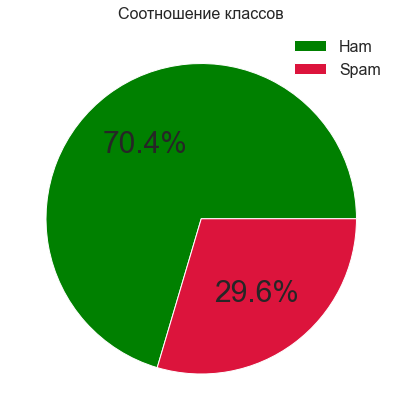

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7), dpi = 72)

ax.pie(df_cleaned["text_type"].value_counts(), autopct = '%1.1f%%', colors = ['g', 'crimson'])
plt.title("Соотношение классов")
plt.ylabel("")
plt.legend(["Ham", "Spam"], loc = 1)


plt.show()

Как видим по диаграмме выше, ham сообщений в датасете 70%, что намного больше, чем spam:

-  Можно почистить датасет для баланса классов 1:1, но это приведет к потере большого количества данных
-  Нельзя использовать такие метрики как accuracy
-  При разделении на выборки придется использовать стратификацию




**Частотность слов**

In [24]:
# облако слов
def showWordCloud(words, title):   
    wordcloud_words = WordCloud(background_color='white' , width=800, height=600).generate(" ".join(words))
    
    plt.figure(figsize=(10,7), dpi = 72)
    plt.imshow(wordcloud_words)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.tight_layout(pad=0)
    plt.show()

In [25]:
# ham слова
ham_words = []
for i in df_cleaned["lemmas"][df_cleaned["text_type"]==0]:
    ham_words.append(' '.join([row for row in i]))
ham_words = ''.join(ham_words).split()

In [26]:
# spam слова
spam_words = []
for i in df_cleaned["lemmas"][df_cleaned["text_type"]==1]:
    spam_words.append(' '.join([row for row in i]))
spam_words = ''.join(spam_words).split()

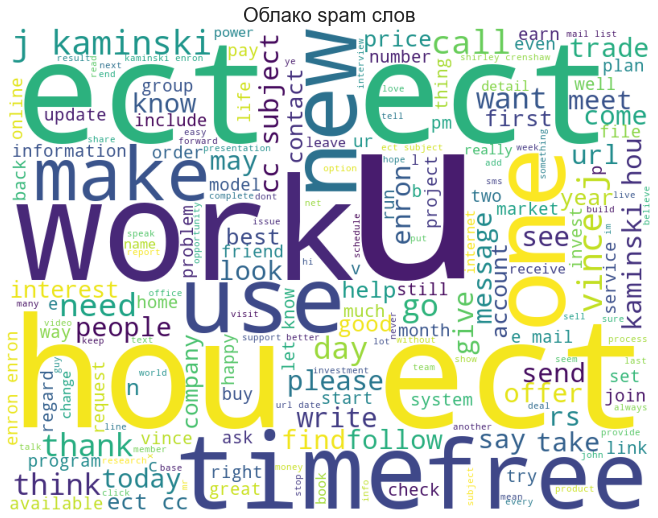

In [27]:
showWordCloud(spam_words, "Облако spam слов")

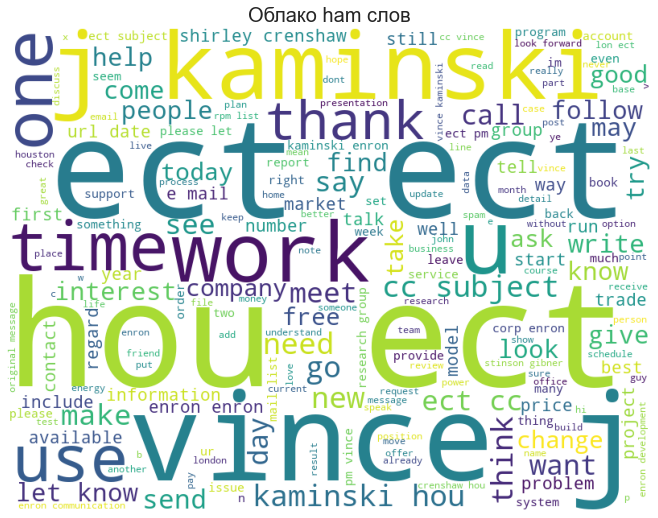

In [28]:
showWordCloud(ham_words, "Облако ham слов")

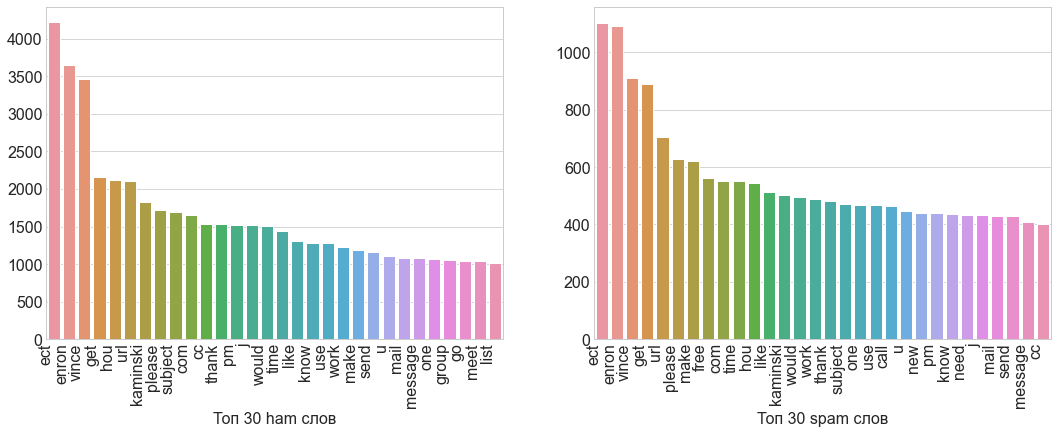

In [29]:
ham_words_30  = pd.DataFrame(nltk.FreqDist(ham_words).most_common(30),  columns=['word', 'count'])
spam_words_30 = pd.DataFrame(nltk.FreqDist(spam_words).most_common(30), columns=['word', 'count'])

fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi = 72)

sns.barplot(x='word', y='count', data=ham_words_30, ax=ax[0])
ax[0].set_xlabel("Топ 30 ham слов")
ax[0].set_ylabel("")
ax[0].set_xticks(ax[0].get_xticks(), ax[0].get_xticklabels(), rotation=90, ha='right')


sns.barplot(x='word', y='count', data=spam_words_30, ax=ax[1])
ax[1].set_xlabel("Топ 30 spam слов")
ax[1].set_ylabel("")
ax[1].set_xticks(ax[1].get_xticks(), ax[1].get_xticklabels(), rotation=90, ha='right')

plt.show()

**SPAM**
- Тенденция к многократному повторению определенных ключевых слов (u, free, time, now)
- Пространство между очень большими словами заполняют очень маленькие

**HAM**
- БОльшая дисперсия
- Используется много сокращений (cc, url)
- Лексика неформальная и общеупотребительная
- В словах допускаются опечатки

**Длина сообщений**

In [30]:
len_df = pd.DataFrame()
len_df["len_chars"] = df_cleaned["cleaned"].apply(len)
len_df["len_words"]= df_cleaned["tokens"].apply(len)
len_df["len_sentences"]= df_dedupped.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)


len_df.describe()[1:].T

,mean,std,min,25%,50%,75%,max
len_chars,285.828925,275.855393,0.0,50.0,140.0,581.0,800.0
len_words,52.232837,49.515074,0.0,10.0,27.0,103.0,175.0
len_sentences,1.062131,0.376097,1.0,1.0,1.0,1.0,12.0


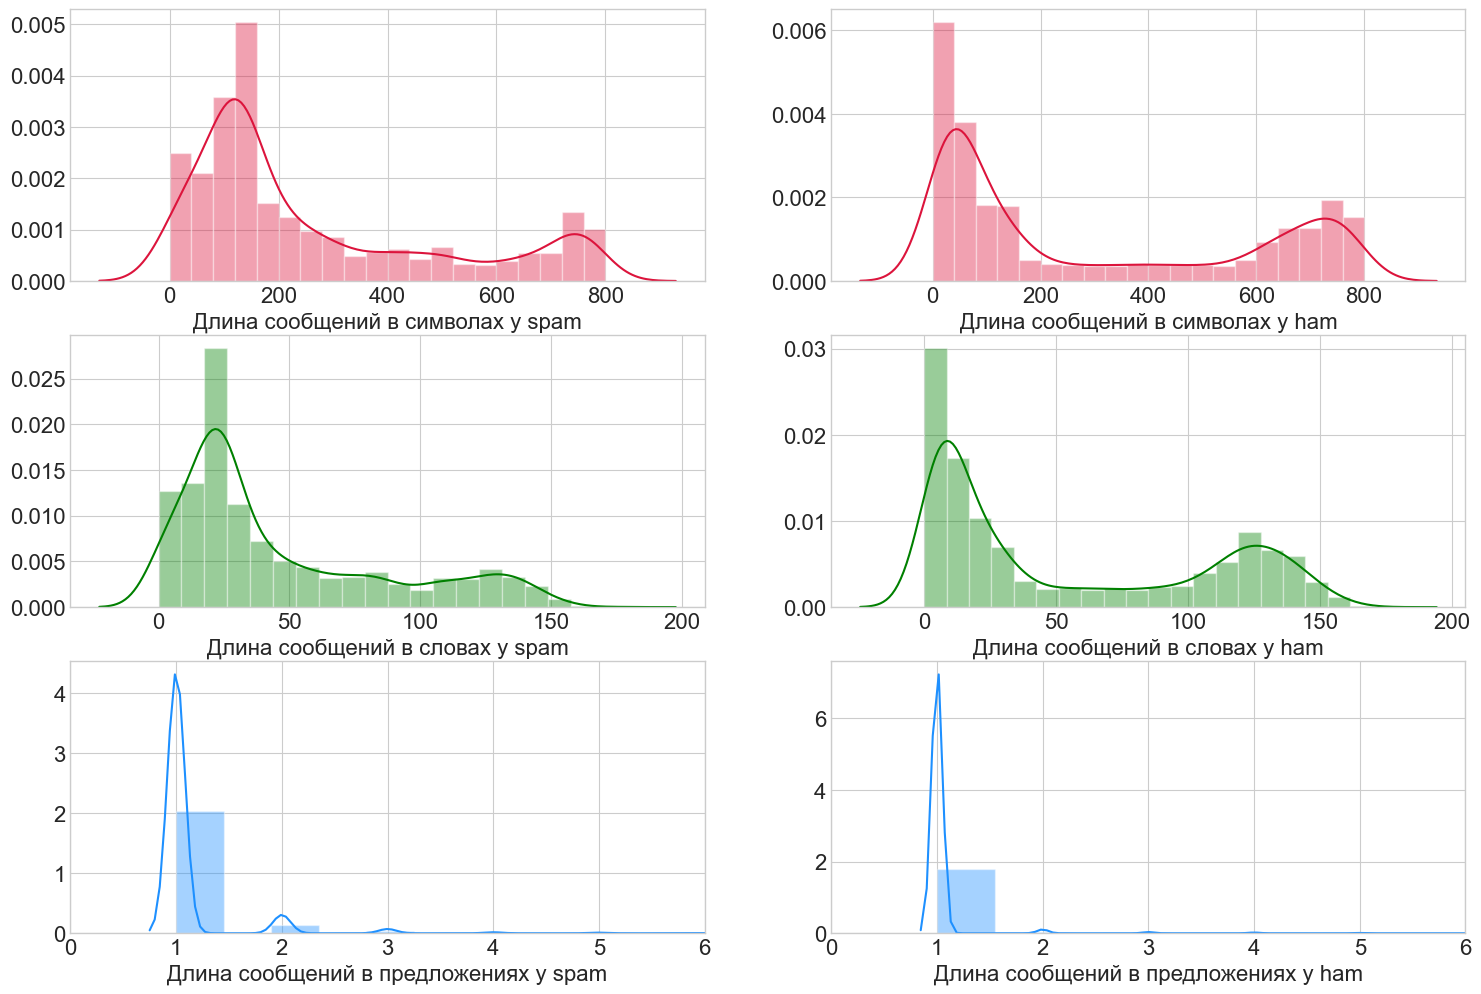

In [31]:
fig, ax = plt.subplots(3, 2, figsize = (18, 12))

sns.distplot(len_df[df_dedupped["text_type"] == "spam"]["len_chars"], bins = 20, ax = ax[0, 0], color = 'crimson')
ax[0, 0].set_xlabel("Длина сообщений в символах у spam")
ax[0, 0].set_ylabel("")

sns.distplot(len_df[df_dedupped["text_type"] == "ham"]["len_chars"], bins = 20, ax = ax[0, 1], color = 'crimson')
ax[0, 1].set_xlabel("Длина сообщений в символах у ham")
ax[0, 1].set_ylabel("")


sns.distplot(len_df[df_dedupped["text_type"] == "spam"]["len_words"], bins = 20, ax = ax[1, 0], color = 'g')
ax[1, 0].set_xlabel("Длина сообщений в словах у spam")
ax[1, 0].set_ylabel("")

sns.distplot(len_df[df_dedupped["text_type"] == "ham"]["len_words"], bins = 20, ax = ax[1, 1], color = 'g')
ax[1, 1].set_xlabel("Длина сообщений в словах у ham")
ax[1, 1].set_ylabel("")


sns.distplot(len_df[df_dedupped["text_type"] == "spam"]["len_sentences"], bins = 20, ax = ax[2, 0], color = 'dodgerblue')
ax[2, 0].set_xlabel("Длина сообщений в предложениях у spam")
ax[2, 0].set_ylabel("")
ax[2, 0].set_xlim(0,6)

sns.distplot(len_df[df_dedupped["text_type"] == "ham"]["len_sentences"], bins = 20, ax = ax[2, 1], color = 'dodgerblue')
ax[2, 1].set_xlabel("Длина сообщений в предложениях у ham")
ax[2, 1].set_ylabel("")
ax[2, 1].set_xlim(0,6);

plt.show()

- Ham-сообщения в основном либо очень короткие, либо наоборот очень длинные. Спам сообщения колеблются около пика ~150 символов, хотя определенная группа сообщений доходит почти до 800 символов
- Относительно кол-ва слов картина практически схожа - у ham имеется резкий спад на 50-100 словах
- В спаме в среднем используется предложений меньше, чем в ham

## Обучение модели ##

**Очистка данных**


In [32]:
# делим выборку на обучающую и валидационную c CountVectorizer
X_train_bag, X_val_bag, y_train, y_val = train_test_split(X_bag, df_cleaned["text_type"], 
                                                                  random_state = 42, 
                                                                  stratify = df_cleaned["text_type"],
                                                                  test_size = 0.15)

In [33]:
# TF-IDF
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, df_cleaned["text_type"], 
                                                              random_state = 42, 
                                                              stratify = df_cleaned["text_type"], 
                                                              test_size = 0.15)

**Обучим модель на KNN**

In [37]:
KNN = KNeighborsClassifier()
KNN.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [42]:
print("KNN:", cross_val_score(KNN, X_train_bag, y_train ,scoring="roc_auc", cv=5).mean())

KNN: 0.5127691179793821


**Выбор лучшей модели**

Попробуем разные стандартные модели машинного обучения, потому что данных не так много:

- К ближайших соседей
- Наивный Баесовский классификатор
- Случайный лес
- SVC
- SGD
- Градиентный бустинг

In [34]:
classifiers = [KNeighborsClassifier(),
               MultinomialNB(), 
               RandomForestClassifier(), 
               SVC(), 
               SGDClassifier(), 
               XGBClassifier()]

In [ ]:
def fitModels(X_train, y_train, classifiers):
    
    # обучаем на каждом классификаторе
    for model in classifiers:
        model.fit(X_train, y_train)
        

In [ ]:
def scoreModels(X_train,y_train, classifiers)
    cls_names = {0: "KNeighbours", 1: "NaiveBayes", 2: "RandomForest", 3: "SVC", 4:"SGD", 5:"GradientBoost"}
    
    # Скор на тестовой с 5-fold кросс-валидацией
    for i, model in enumerate(classifiers):
        cv_score = cross_val_score(model, X_train,y_train,scoring="roc_auc", cv=5)
        print(cls_names[i], cv_score.mean())

In [ ]:
# на CountVectorizer
fitModels(X_train_bag, y_train, classifiers)
scoreModels(X_val_bag, y_val, classifiers)

In [ ]:
# на TF-IDF
fitModels(X_train_bag, y_train, classifiers)
scoreModels(X_val_bag, y_val, classifiers)

**Скейлинг данных**

Можно попробовать нормализовать векторы для лучшей работы моделей:

In [161]:
scaler = MinMaxScaler()

# CountVectorizer
X_train_bag_scaled = scaler.fit_transform(X_train_bag)
X_val_bag_scaled  = scaler.transform(X_val_bag)

# TF-IDF
X_train_tfifd_scaled = scaler.fit_transform(X_train_tfidf)
X_val_tfidf_scaled  = scaler.transform(X_val_tfidf)

In [ ]:
# CountVectorizer
fitModels(X_train_bag_scaled, y_train, classifiers)
scoreModels(X_val_bag_scaled, y_val, classifiers)

In [ ]:
# TF-IDF
fitModels(X_train_tfifd_scaled, y_train, classifiers)
scoreModels(X_val_tfidf_scaled, y_val, classifiers)

Честно сказать я успела все сделать, но не успела обучить модельки, и следовательно выбрать из них лучшую... По хорошему нужно бы было сперва обучить все модели, посчитать у них скор, построить ROC-кривую и confusion matrix для каждого классификатора. Но дедлайны, к сожалению, прижали меня, поэтому обучить модели не успеваю. И на тестовом файле соотвественно скор сделан по KNN, которая быстро учится, но у нее ужасный скор выходит... Как будто бы это лучше, чем ничего, но вот похуже, чем хорошо

**Оценка моделей**

In [44]:
# Обучаем лучшую модель на всей выборке 
clf = KNeighborsClassifier()
clf.fit(X_bag, df_cleaned["text_type"])

KNeighborsClassifier()

In [45]:
y_pred_bag = KNN.predict(X_bag) 

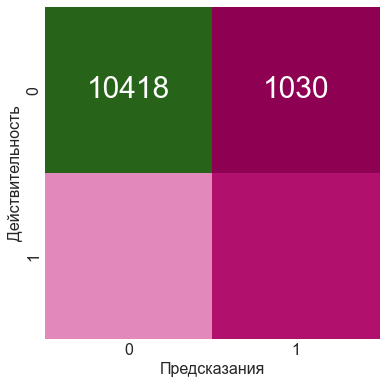

In [46]:
def plotConfusionMatrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(6,6), dpi = 72)
    
    sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True,
                fmt='d',
                cmap = "PiYG",
                cbar=False,
                ax=ax)
    plt.ylabel('Действительность')
    plt.xlabel('Предсказания')

plotConfusionMatrix(df_cleaned["text_type"], y_pred_bag)

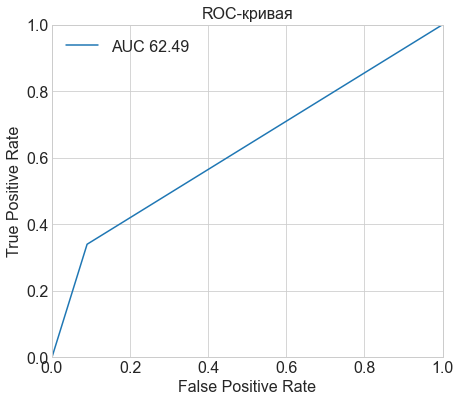

In [48]:
fpr, tpr, thr = roc_curve(df_cleaned["text_type"], y_pred_bag)

plt.subplots(figsize=(7, 6), dpi = 72)
plt.plot(fpr, tpr)
plt.axis([0, 1, 0, 1]) 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

auc_knn4 = auc(fpr, tpr) * 100
plt.legend(["AUC {0:.2f}".format(auc_knn4)])

plt.show()

## Скоринг данных ##

In [49]:
# чтение тестового датасета
df_test = pd.read_csv("test_spam.csv")
print(df.shape)
df.head()

(16278, 2)


,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [50]:
df_test_cleaned = pd.DataFrame()
# очистка от символов
df_test_cleaned["cleaned"] = df_test["text"].apply(cleanText)

# перевод в нижний регистр
df_test_cleaned["lowercase"] = df_test_cleaned["cleaned"].str.lower()

# токенизация
df_test_cleaned["tokens"] = df_test_cleaned["lowercase"].apply(tokenizeText)

# удаление стоп-слов
df_test_cleaned["without_stopwords"] = df_test_cleaned["tokens"].apply(removeStopwords)

# лемматизация
df_test_cleaned["lemmas"] = df_test_cleaned["without_stopwords"].apply(lemmatizeWord)

# векторизация
test_rows = []
for i in df_test_cleaned["lemmas"]:
    test_rows.append(' '.join([row for row in i]))

X_test_bag = bag.transform(test_rows).toarray()
    

In [52]:
# скорим модель
df_test["score"] = clf.predict(X_test_bag)

In [53]:
df_test["text"][df_test["score"]== 0]

0       j jim whitehead ejw cse ucsc edu writes j you ...
1       original message from bitbitch magnesium net p...
3                    there is a youtuber name saiman says
4       underpriced issue with high return on equity t...
5                               aight lemme know whats up
                              ...                        
4065    husband to wifetum meri zindagi hoorwifeor kya...
4066    baylor enron case study cindy yes i shall co a...
4067                             boring as compared to tp
4068    hellogorgeous hows u my fone was on charge lst...
4069    energy conference mark we are really swamped a...
Name: text, Length: 3261, dtype: object

In [54]:
def targetToString(row):
    if row==0:
        return "ham"
    if row==1:
        return "spam"

df_test["score"] = df_test["score"].apply(targetToString)

In [55]:
# записываем в файлик 
df_test.to_csv('scoring.csv')